In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from skimage.transform import resize

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    d = pydicom.dcmread(filename)  
    try:
        assert(d.Modality == "DX")
        assert(d.BodyPartExamined == 'CHEST')
        assert(d.PatientPosition in ['PA', 'AP'])                          
    except Exception as e:
        print('File {} contains invalid data'.format(filename))
        return (None, None)
    
    img = d.pixel_array
    return (img, d)
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_size): 
    normalized_img  = img / 255
    resized_img = resize(img, (img_size[1], img_size[2]))
    proc_img = resized_img.reshape((1, img_size[1], img_size[2], 1))
    proc_img = np.repeat(proc_img, img_size[3], axis=3)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    with open(model_path, 'r') as json_file:
        model_file = json_file.read()
        model = keras.models.model_from_json(model_file)
        model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    if model.predict(img)>thresh:
        return 'Pneumonia'
    else:
        return 'No Pneumonia'

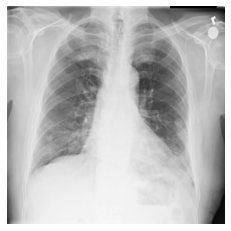

Prediction: No Pneumonia
Finding: No Finding




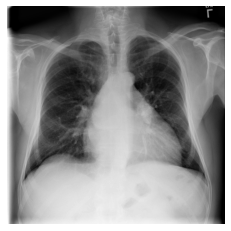

Prediction: No Pneumonia
Finding: Cardiomegaly




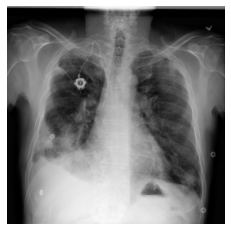

Prediction: Pneumonia
Finding: Effusion


File test4.dcm contains invalid data
File test5.dcm contains invalid data
File test6.dcm contains invalid data


In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "my_model.json"
weight_path = "{}_my_model.best.hdf5".format('xray_class')

IMG_SIZE=(1,224,224,3)

my_model = load_model(model_path, weight_path)
thresh = 0.51

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img, dicomFile = check_dicom(i)
    
    if img is None:
        continue
        
    if dicomFile is None:
        print("no dicomn file")
        
    sd = dicomFile.StudyDescription
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
        
    img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print('Prediction:', pred)
    print('Finding:', sd)
    print("")
    print("")